# Libraries and imports

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

from src.data_preparation_workflow import load_and_merge, load_dataset
from src.utils import plot_salary_distribution, plot_correlation_matrix, plot_salary_boxplot_by_category

In [2]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Paths

# Raw data paths
paths = ['../data/people.csv',
         '../data/salary.csv',
         '../data/descriptions.csv']

# Table of Contents

## Table of Contents

1. [Introduction](#introduction)
2. [Very quick overview of the dataset](#very-quick-overview-of-the-dataset)
3. [Project Structure](#project-structure)
4. [Data Preparation Workflow](#data-preparation-workflow)
5. [Model Classes](#model-classes)
    - 5.1 [Linear Models preprocessing](#linear-models-preprocessing)
    - 5.2 [Tree Based Models preprocessing](#tree-based-models-preprocessing)
    - 5.3 [Metrics and Bootstrap Confidence Intervals](#metrics-and-bootstrap-confidence-intervals)
6. [Model Implementation Overview](#model-implementation-overview)
    - 6.1 [Baseline Model (`dummy_model`)](#1-baseline-model-dummy_model)
    - 6.2 [Linear Model (`LinearModel`)](#2-linear-model-linearmodel)
    - 6.3 [Decision Tree Model (`DecisionTree`)](#3-decision-tree-model-decisiontree)
    - 6.4 [Random Forest Model (`RandomForest`)](#4-random-forest-model-randomforest)
    - 6.5 [Models Summary](#models-summary)
7. [User interface and API](#user-interface-and-api)
    - 7.1 [API implementation](#api-implementation)
    - 7.2 [UI](#ui)

---

# Introduction

The challenge consisted of creating a salary prediction application using different machine learning models, evaluating their performance with a sensible metric, and presenting the results in a clear and concise manner, ideally using some form of visualization/UI.

We have been given 3 files:
- people.csv: Contains information about people, including their age, level of education, job title, years of experience, and salary.
- salary.csv: Contains people identifiers and their corresponding salaries.
- descriptios.csv: Contains descriptions each person has written about themselves.

The *goal* is to predict the salary of a person based on their attributes and description.

This report presents a comprehensive solution to the challenge, including data preprocessing, model training, evaluation and visualization of results. All while keeping in mind the best practices in software development, such as modularity, OOP principles, logging and code quality. 

From trained models, the optimized RandomForest regressor resulted in the best performance, achieving an R² score of **0.936** with a 95% confidence interval of **[0.895, 0.965]** and a RMSE of **$12,941** with a 95% confidence interval of **[$9780.574, $16098.963]**.

The solution is presented in a clean and intuitive UI that on a later chapter will be explained how to run. 


---

# Very quick overview of the dataset

The 3 files were linked by an 'id' field, which is the unique identifier for each person. 
The resulting dataset then is:

In [4]:
df = load_and_merge(paths, "id")
df

,id,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Description
0,0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,I am a 32-year-old male working as a Software ...
1,1,28.0,Female,Master's,Data Analyst,3.0,65000.0,I am a 28-year-old data analyst with a Master'...
2,2,45.0,Male,PhD,Senior Manager,15.0,150000.0,I am a 45-year-old Senior Manager with a PhD a...
3,3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,I am a 36-year-old female Sales Associate with...
4,4,52.0,Male,Master's,Director,20.0,200000.0,I am a 52-year-old male with over two decades ...
...,...,...,...,...,...,...,...,...
370,370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,85000.0,As a 35-year-old Senior Marketing Analyst with...
371,371,43.0,Male,Master's,Director of Operations,19.0,170000.0,I am a 43-year-old male with a Master's degree...
372,372,29.0,Female,Bachelor's,Junior Project Manager,2.0,40000.0,As a 29-year-old female Junior Project Manager...
373,373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,90000.0,As a Senior Operations Coordinator with a Bach...


In [5]:
df.describe()

,id,Age,Years of Experience,Salary
count,375.000000,370.000000,373.000000,373.000000
mean,187.000000,37.437838,10.030831,100577.345845
std,108.397417,7.080465,6.557007,48240.013482
min,0.000000,23.000000,0.000000,350.000000
25%,93.500000,31.250000,4.000000,55000.000000
50%,187.000000,36.000000,9.000000,95000.000000
75%,280.500000,44.000000,15.000000,140000.000000
max,374.000000,53.000000,25.000000,250000.000000


As we can see from the summary statistics, the numerical variables are within reasonable ranges, but there was a strange case of a young guy working as a Junior Business Operations Analyst who was earning $350.00. The decision on this individual was to *adjust the salary by a factor of 1000* during the dataset preparation.

In [6]:
df[df['Salary'] < 1000]

,id,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Description
259,259,29.0,Male,Bachelor's,Junior Business Operations Analyst,1.5,350.0,As a 29-year-old Junior Business Operations An...


Let's also quickly visualize the **distribution** of the target variable, which is the salary:

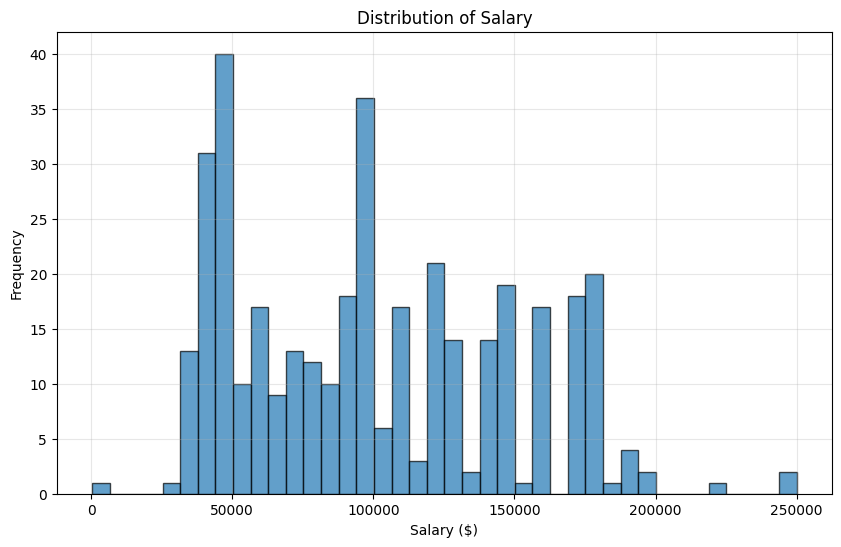

In [7]:
plot_salary_distribution(df)

We can clearly see that the bulk of the salaries are between $40,000 and $200,000 with a few higher salaries from directors and top executives - and some records with missing salary.

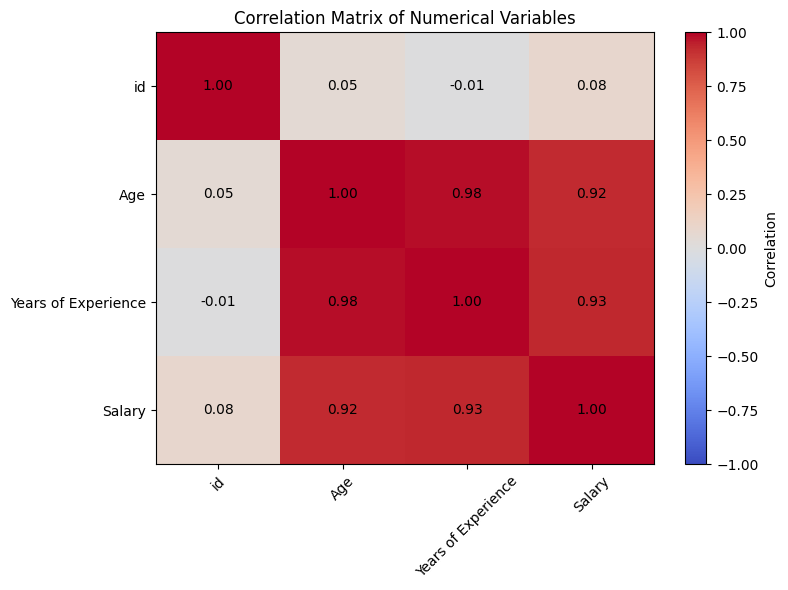

In [8]:
plot_correlation_matrix(df)

And as expected, the **correlation matrix** shows that the salary is positively correlated with the years of experience - which to no one's surprise, its also highly correlated with Age.

Then, **Education Level** is a categorical variable with 3 levels:
- *Bachelor's*
- *Master's*
- *PhD*

In [9]:
df['Education Level'].value_counts()

Education Level
Bachelor's    222
Master's       97
PhD            51
Name: count, dtype: int64

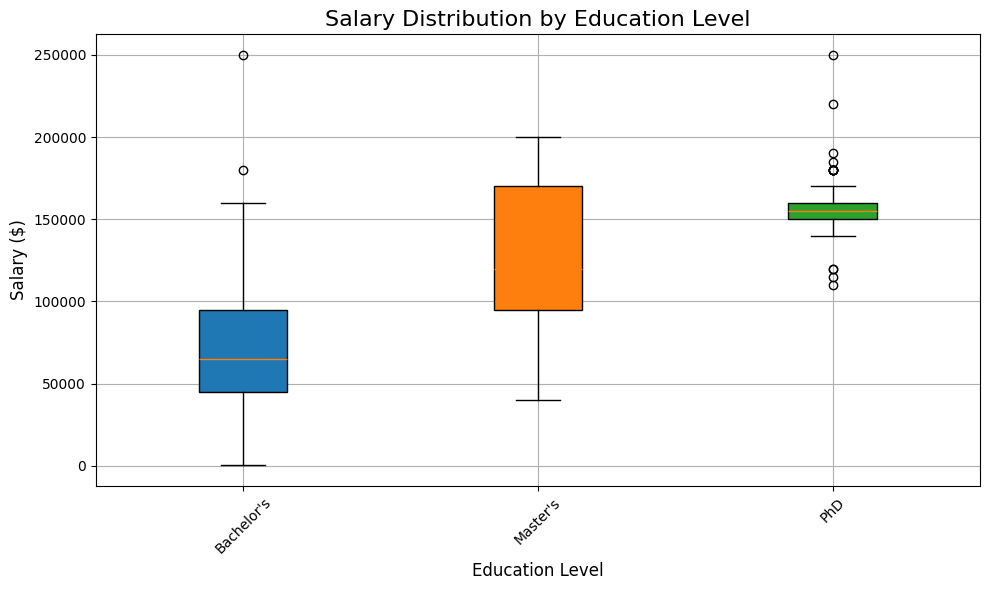

In [10]:
plot_salary_boxplot_by_category(df, 'Education Level')

From the box plot above, its clear that progressing from Bachelor's to Master's and then to PhD, tends to increase the salary, with PhD holders earning the most on average.

Let's see what happens with **Gender**:

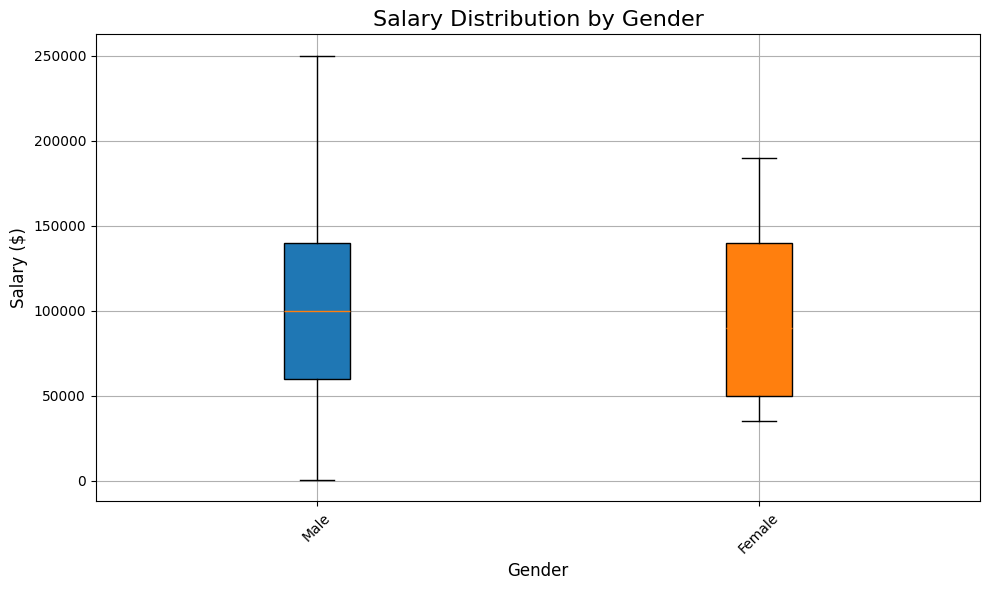

In [11]:
plot_salary_boxplot_by_category(df, 'Gender')

So, the box plot shows both male and females centered around the same salary, but with Males having a wider range of salaries, both to the lower and upper ends.

**Job Titles** have been thoroughly studied and transformed in the data preparation workflow, which will be explained in the next section.






Let's now continue with the main data preparation workflow. But first a quick overview of the project structure.

---

# Project Structure

The project is structured in a modular way, with separate folders for the data, trained models, notebooks and backend code.

The **src** folder contains the main API componentes and UI, as well as model classes and utility functions, and the core data preparation workflow.


<pre style="font-family: 'Courier New', monospace; background-color: #f5f5f5; padding: 10px; border-radius: 5px;">
.
├── data/
│   └── cleaned_data/
├── models/
├── notebooks/
├── report/
└── src/
    ├── api/
    │   ├── api_testing/
    │   └── UI/
    ├── data_preparation_workflow/
    └── models/
</pre>

---

# Data Preparation Workflow

The data preparation workflow is orchestrated through the orchestrator.py file, which applies several key transformations to prepare the raw data for modeling.

<pre style="
    font-family: 'Courier New', monospace; 
    background-color: #f8f9fa; 
    padding: 15px; 
    border-radius: 8px; 
    border-left: 4px solid #007acc; 
    font-size: 14px; 
    line-height: 1.4;
">
data_preparation_workflow/
├── <b>FE_text.py</b> [2]
├── __init__.py
├── load_and_merge.py [1]
├── loader.py
└── <b>orchestrator.py</b> [3]
</pre>

The *Orchestrator* starts by loading the 3 raw .CSV and merging them into a single Pandas DataFrame, using the **load_and_merge.py** [1] module.

Then:

1. Removes rows where the salary is missing, as we cannot train a model without a target variable.

2. Text features addition.

   2.1 From the **descriptions** string, I created 4 new columns to count the number of nouns, verbs, adjectives and adverbs in the text, using the **get_pos_tags** function from the **FE_text.py** [2] module.

   2.2 Fill missing demographic data (such as Gender, Age, Education level) using *job description* information through the **fill_missing_data** function. This functions uses openAI's gpt-4o-mini model to extract missing data. Its a cheap and effective model for this task. More on the costing at the end of the report.

   2.3 Extract structured job information (Seniority, Area, Role) from job titles using LLM-powered analysis via **extract_job_title_info**. This functions uses openAI's gpt-4o-mini model to extract missing data. Its a cheap and effective model for this task. More on the costing at the end of the report.

   2.4 Standardize job Areas and Roles using **aggregate_categories**. The idea was to create a more manageable set of features by grouping similar areas and roles together, avoiding the sparsity of having too many unique values in the dataset.



3. Final data cleaning phase.

   3.1 Remove any remaining rows with null values using the **remove_nulls** function.

   3.2 Apply salary adjustments and normalizations using **adjust_salary**. Mostly for the case of the young guy earning $350.00, which was adjusted to $35000.00.

4. Column cleanup and export.

   4.1 Drop unnecessary columns: **id**, **Job Title**, **Description**.

   4.2 Save the final processed dataset to **data/cleaned_data/final_dataset.csv**.

Final dataset preview:

In [17]:
final_df = load_dataset('../data/cleaned_data/final_dataset.csv')
final_df

,Age,Gender,Education Level,Years of Experience,Salary,noun_count,verb_count,adj_count,adv_count,Seniority,Area,Role
0,32.0,Male,Bachelor's,5.0,90000.0,22,10,10,0,Senior,Software/data,Engineer
1,28.0,Female,Master's,3.0,65000.0,24,13,7,3,Junior,Software/data,Analysis
2,45.0,Male,PhD,15.0,150000.0,26,13,13,0,Senior,Other,Management
3,36.0,Female,Bachelor's,7.0,60000.0,26,10,6,0,Senior,Sales & Marketing,Individual Contributor
4,52.0,Male,Master's,20.0,200000.0,23,16,8,3,C-level,Business,Leadership
...,...,...,...,...,...,...,...,...,...,...,...,...
361,35.0,Female,Bachelor's,8.0,85000.0,33,14,14,0,Senior,Sales & Marketing,Analysis
362,43.0,Male,Master's,19.0,170000.0,27,13,12,2,C-level,Finance & Operations,Leadership
363,29.0,Female,Bachelor's,2.0,40000.0,31,12,5,2,Junior,Management,Management
364,34.0,Male,Bachelor's,7.0,90000.0,22,10,6,0,Senior,Finance & Operations,Support


And so the final categories are:

In [18]:
print("Unique Seniority levels:")
print(final_df['Seniority'].unique())
print(f"\nCount: {final_df['Seniority'].nunique()}")

print("\n" + "="*50)

print("\nUnique Areas:")
print(final_df['Area'].unique())
print(f"\nCount: {final_df['Area'].nunique()}")

print("\n" + "="*50)

print("\nUnique Roles:")
print(final_df['Role'].unique())
print(f"\nCount: {final_df['Role'].nunique()}")

Unique Seniority levels:
['Senior' 'Junior' 'C-level' 'Principal']

Count: 4


Unique Areas:
['Software/data' 'Other' 'Sales & Marketing' 'Business' 'Product & Design'
 'People & Support' 'Finance & Operations' 'Management']

Count: 8


Unique Roles:
['Engineer' 'Analysis' 'Management' 'Individual Contributor' 'Leadership'
 'Support' 'TopExecs' 'Creative' 'Other']

Count: 9


With this initial pre processing we are ready to jump to the next section, model classes. 

Further preprocessing required by models is handled inside the model classes themselves. 

---

# Model Classes

Why classes? Because they allow us to encapsulate the model logic, making it easier to manage and extend in the future while following the DRY principle (dont repeat yourself), reusing as many methods as possible accross classes.

Each model class is responsible for its own data preprocessing, training, evaluation and prediction methods as well as creating vizualizations. Additionally, since I also wanted to implement a UI, using classes allows for an easier plug-and-play approach, where we can easily add or remove functionality without affecting the overall structure of the code. 



The next *tree* shows the classes in a hierarchical way - that is, the classes that inherit from other classes are shown as children of the parent class:



<pre style="
    font-family: 'Courier New', monospace; 
    background-color: #f8f9fa; 
    padding: 15px; 
    border-radius: 8px; 
    border-left: 4px solid #e74c3c; 
    font-size: 14px; 
    line-height: 1.4;
">
📁 Model Architecture
├── 🔧 <b>ABC</b> (Abstract Base Class)
├── 🔌 <b>APIwrapper</b> (Mixin Class)
│   ├── save() / load() methods
│   ├── API compatibility
│   ├── Model metadata management
│   └── 🔍 <b>SHAP integration</b> (predict_api_input)
│
└── 🎯 <b>BaseModel(ABC, APIwrapper)</b>
    ├── fit() / predict() interface
    ├── Bootstrap confidence intervals  
    ├── Model evaluation methods
    ├── 📊 <b>Visualization</b>: plot_predictions()
    ├── 🔍 <b>SHAP</b>: LinearExplainer
    │
    ├── 🌳 <b>DecisionTree(BaseModel)</b>
    │   ├── Scikit-learn DecisionTreeRegressor
    │   ├── Custom preprocessing pipeline
    │   ├── GridSearch optimization
    │   ├── 📊 <b>Visualization</b>
    │   ├── 🔍 <b>SHAP</b>: TreeExplainer
    │   │
    │   └── 🌲🌲 <b>RandomForest(DecisionTree)</b>
    │       ├── Scikit-learn RandomForestRegressor
    │       ├── Inherits DecisionTree preprocessing
    │       ├── Optuna optimization
    │       ├── 📊 <b>Visualization</b>
    │       └── 🔍 <b>SHAP</b>: TreeExplainer
    │
    └── 📈 <b>LinearModel(BaseModel)</b>
        ├── Multiple algorithms (OLS, Ridge, Lasso, SGD)
        ├── VIF multicollinearity removal
        ├── SelectKBest feature selection
        ├── 📊 <b>Visualization</b>
        └── 🔍 <b>SHAP</b>: LinearExplainer for coefficients
</pre>

I will not expand further on the classes and the methods, as it would make this report too long and might loose focus on the main goal of the challenge, which is to predict salaries.

**But** I will highlight some key points:
- Linear models preprocessing steps
- Tree based algorithms preprocessing steps
- Metrics and bootstrap confidence intervals

### Linear Models preprocessing

<pre style="
    font-family: 'Courier New', monospace; 
    background-color: #f8f9fa; 
    padding: 15px; 
    border-radius: 8px; 
    border-left: 4px solid #17a2b8; 
    font-size: 14px; 
    line-height: 1.4;
">
<b>LinearModel Preprocessing Pipeline</b>

1. <b>Min-Max Scaling</b> (Numerical Features)
   • Scales all numerical values to [0,1] range
   • Why: Linear models sensitive to feature magnitude
   • Example: Age (20-60) and Salary (30K-200K) → both become 0-1

2. <b>One-Hot Encoding</b> (Categorical Features)  
   • Converts categories into binary columns
   • Why: Linear models need numerical inputs
   • Example: Gender → Gender_Male, Gender_Female (0 or 1)

3. <b>SelectKBest</b> (f_regression)
   • Selects top-k most predictive features using F-statistics
   • Why: Removes irrelevant features that add noise
   • Example: Keep top 15 features from 25 total features

4. <b>VIF Selection</b> (Multicollinearity Removal)
   • Removes features with high correlation (VIF > 5.0)
   • Why: Linear models unstable with correlated predictors
   • Example: Remove "Years_Experience" if highly correlated with "Age"
</pre>

**Observations:**


- **Is min-max scaling the best approach?** Not necessarily, but it is a simple and effective way to ensure that all numerical features are on the same scale, which is important for linear models.
- **Why feature selection?** Ockham's Razor principle: simpler models with fewer features are often more robust and interpretable.
- **Is VIF selection mandatory?** Not always, but it ensures coefficient stability and interpretability by removing multicollinearity. It is important when showing the *feature_importance* by ranking the coefficients - we dont want them changing time after time. 

### Tree Based Models preprocessing

<pre style="
    font-family: 'Courier New', monospace; 
    background-color: #f8f9fa; 
    padding: 15px; 
    border-radius: 8px; 
    border-left: 4px solid #28a745; 
    font-size: 14px; 
    line-height: 1.4;
">
<b>Tree-Based Models Preprocessing Pipeline</b>

1. <b>Ordinal Encoding</b> (Hierarchical Features)
   • Preserves natural order in categorical features
   • Why: Trees can split on meaningful order (Junior < Senior < Director)
   • Example: Education Level → High School(1), Bachelor's(2), Master's(3), PhD(4)

2. <b>One-Hot Encoding</b> (Remaining Categorical Features)
   • Converts non-ordinal categories into binary columns
   • Why: No natural order exists (Gender, Job Area)
   • Example: Job Area → Area_Finance, Area_Tech, Area_Marketing (0 or 1)

3. <b>Optional Normalization</b> (Numerical and Ordinal Features)
   • Scales numerical values to [0,1] range (when enabled)
   • Why: Trees don't require scaling but may improve performance
   • Example: Age, Years_Experience → scaled to 0-1 (optional)


</pre>

### Metrics and Bootstrap Confidence Intervals

Chosen metric of reference: **RMSE** (Root Mean Squared Error)

Additional metrics: 

-**R²** (Coefficient of Determination)

-**MAE** (Mean Absolute Error)

Why RMSE? it provides an error measure in the same units as the target variable (salary), making it more interpretable. It penalizes larger errors more than smaller ones, which is a nice perk for salary prediction.

R² indicates how much of the variance in the salary is explained by my model. I like to use it as a sanity check, as it should be close to 1 for a good model.

MAE is a simple average of the absolute errors, which is also interpretable but less sensitive to large errors compared to RMSE as it treats all errors equally.

#### Bootstrap Confidence Intervals

The base class implements a method to calculate metrics confidence intervals for the model's predictions using bootstrap. This is done by resampling the data with replacement and calculating the 3 metrics for each sample, allowing us to estimate the uncertainty of our predictions.

The default number of bootstrap iterations is set to 500, with an alpha level of 0.05, which gives us a 95% confidence interval for the metrics, and a sampling proportion of 80%. That means that during every iteration, 80% of the data is sampled with replacement to calculate the metrics, and the remaining 20% is used to evaluate the model's performance.

After running the bootstrap loop, during which we collected the metrics for each sample - we calculate the 95% confidence interval for each metric by taking the 2.5th and 97.5th percentiles of the bootstrap samples.

This approach follows **Method 3** from the Sebastian Raschka's article on [Bootstrap Confidence Intervals for Model Evaluation Metrics](https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html). Which consists of bootstraping on **the test** set without model retraining. 

According to the article, this method could yield wider intervals than other methods but I like it because it is simple and effective, and it does not require retraining the model for each bootstrap sample, which can be computationally expensive. And also, since our dataset is small, bootstrapping on the trainig data didn't give me much confidence on the results. 

---

# Model Implementation Overview

This section will consist of a brief explanation of the models used, their predictions plots and at the end, a summary of the metrics.

The regressors are all from the *scikit-learn* library.

During the exploration of possible solutions, I have tried with 4 different architectures:

## 1. Baseline Model (`dummy_model`)

**Purpose**: Establishes performance baseline for comparison  
**Algorithm**: Scikit-learn `DummyRegressor`  
**Strategy**: Median-based prediction (outputs median salary from training data)  
**Preprocessing**: None required - ignores feature data  
**Use Case**: Reference point to validate that sophisticated models provide meaningful improvement


Dummy model performance vs real values on test set:

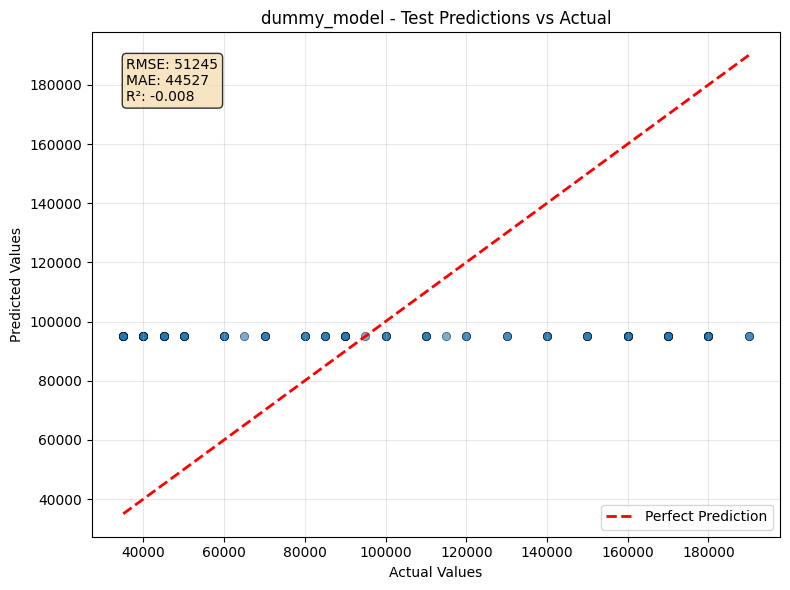

## 2. Linear Model (`LinearModel`)

**Algorithms**: Multiple linear approaches in unified framework
- **OLS**: Standard linear regression
- **Ridge**: L2 regularization for multicollinearity handling  
- **Lasso**: L1 regularization with feature selection properties
- **SGD**: Stochastic Gradient Descent for scalable training

Preprocessing was explained in the previous section -> please refer to the **Linear Models preprocessing** section.

It's worth noting that these linear models were **not subject to parameter optimization**, as time was limited and I wanted to focus on the tree-based models.

**Lasso model with alpha = 100 and k_best = 15** performance vs real values on test set:

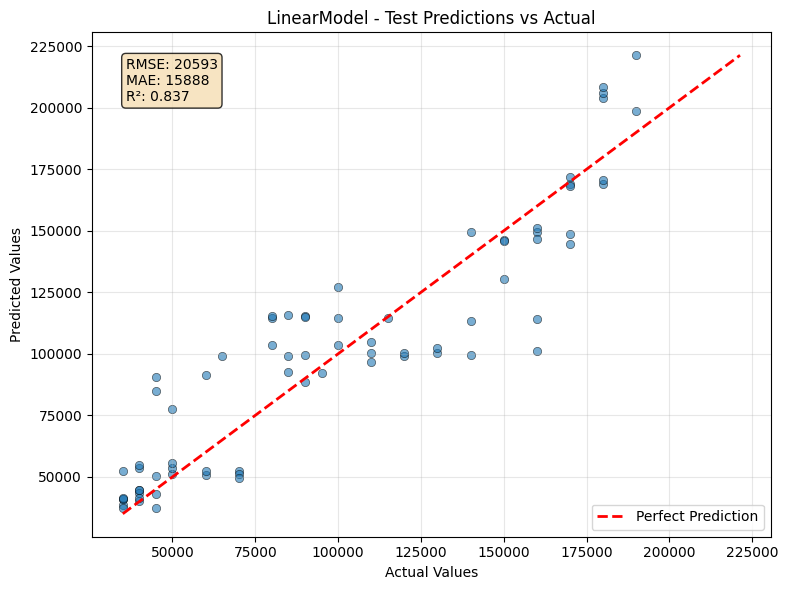

The 4 linear models performed similarly, with the Lasso model being the best performer by a small margin.

## 3. Decision Tree Model (`DecisionTree`)

**Algorithm**: Scikit-learn DecisionTreeRegressor

**Key Features**:
- **Cross Validation**: Supports CV for robust evaluation.
- **Hyperparameter Optimization**: GridSearch for optimal tree parameters.

Preprocessing was explained in the previous section -> please refer to the **Tree Based Models preprocessing** section.

**GridSearchCV Optimization Results:**

| Parameter | Optimal Value | Description |
|-----------|---------------|-------------|
| `ccp_alpha` | **0.0** | No pruning applied (tree at full complexity) |
| `max_depth` | **5** | Maximum tree depth (prevents overfitting) |
| `max_features` | **None** | All features considered at each split |
| `min_samples_leaf` | **2** | Minimum samples required in leaf nodes |
| `min_samples_split` | **30** | Minimum samples required to split internal node |
| `splitter` | **best** | Best node splitting strategy (random or best) |


**Optimized Decision Tree model** performance vs real values on test set:

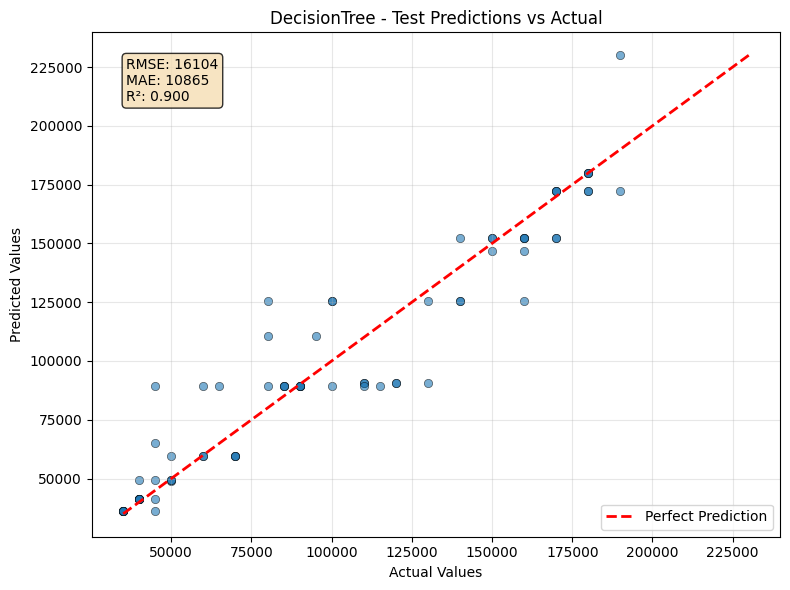

## 4. Random Forest Model (`RandomForest`) 

**Algorithm**: Scikit-learn RandomForestRegressor

**Architecture**: Inherits all DecisionTree preprocessing capabilities  
**Key Enhancements**:
- **Ensemble Power**: Multiple trees reduce overfitting and improve generalization
- **Advanced Optimization**: Optuna Bayesian optimization for efficient hyperparameter search
- **Cross-Validation Integration**: Built-in CV for robust performance estimation
- **Feature Importance**: Aggregated importance across the ensemble

**Optimization Strategy**: Optuna framework for intelligent hyperparameter space exploration with integrated cross-validation.

This optimization approach was my solution to having to run a Bayesian Optimization on very little data. As I used training data for optimizing - that is 366 records, I was worried that the parameter optimization would overfit the model to the training data, so I used cross-validation to mitigate this risk. On every set of parameters proposed by the BO, I would run a 5-fold cross-validation with an 80/20 split, which would give me a more robust estimate of the model's performance on unseen data.


**Optuna Bayesian Optimization Results:**

| Parameter | Optimal Value | Description |
|-----------|---------------|-------------|
| `n_estimators` | **259** | Number of trees in the ensemble |
| `max_depth` | **14** | Maximum depth of individual trees |
| `max_features` | **sqrt** | √(total_features) considered at each split |
| `min_samples_split` | **2** | Minimum samples required to split internal node |
| `min_samples_leaf` | **1** | Minimum samples required in leaf nodes |
| `normalize` | **True** | Feature normalization enabled |
| `random_state` | **37** | Seed for reproducible results |

**Optimized Random Forest** model performance vs real values on test set:

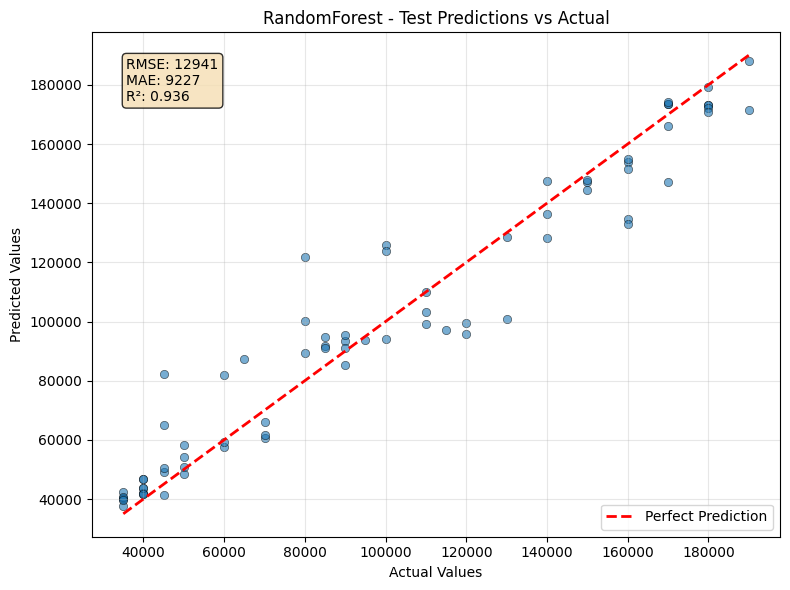

## Models Summary

Every model has beaten the dummy model (wasnt too hard), so I should probably have picked a more challenging baseline.
Though, with the simple initial preprocessing and the subsequent model-specific preprocessing, I was able to achieve a decent results with all models.

As I was expecting, the random forest model outperformed the decision tree model, which in turn outperformed the linear models. Yet, to be fair, the linear models were not optimized and were only trained with the default parameters, so they could have performed better with some hyperparameter tuning.

For a quick MVP, I would say that the Random Forest model is the best choice for this challenge, as it provides the best performance and is also the most robust to overfitting. Given the small dataset, playing around with cross validations and bootstrap confidence intervals, adds a little more confidence to the obtained results.





**Evaluation Metrics with 95% Bootstrap Confidence Intervals**

| Model | RMSE | MAE | R² | RMSE (95% CI) | MAE (95% CI) | R² (95% CI) |
|-------|------|-----|----|--------------|--------------|-----------| 
| **🥇 Random Forest (BO_Optimized)** | **12,941** | **9,227** | **0.936** | (9,781 - 16,099) | (7,154 - 11,721) | (0.895 - 0.965) |
| **🥈 Decision Tree (GS_optimized)** | **18,198** | **12,163** | **0.873** | (13,384 - 22,800) | (8,666 - 15,589) | (0.792 - 0.939) |
| **🥉 Random Forest (No Age/Exp)** | **18,555** | **14,171** | **0.868** | (15,366 - 22,981) | (11,817 - 17,088) | (0.778 - 0.916) |
| Lasso Regression | 20,593 | 15,888 | 0.837 | (16,708 - 23,871) | (12,948 - 18,951) | (0.772 - 0.888) |
| Linear (SGD) | 21,005 | 16,225 | 0.831 | (17,266 - 24,349) | (13,384 - 19,815) | (0.753 - 0.885) |
| Linear (OLS) | 21,814 | 16,810 | 0.817 | (18,104 - 24,688) | (13,903 - 20,334) | (0.736 - 0.874) |
| 📊 Dummy (Median) | 51,245 | 44,527 | -0.008 | (46,072 - 56,756) | (38,595 - 50,744) | (-0.119 - 0.000) |


The 3rd place model, is a Random Forest I trained without the Age and years of experience features, as I wanted to have a separate model that learned better other relevant aspects of a person's profile, to then use in a subsequent ensemble model. But time is finite, so I had to stop there.

---

# User interface and API

## API implementation

For the API and UI, I used the *FastAPI* framework, which the go to framework in python for building APIs. It is fast, easy to use and has great documentation.

The API required me to implement a few extra methods on my model classes, such as `save()` and `load()`, to allow for model persistence and retrieval. Additionally, I implemented a method to generate SHAP values for the model's predictions, which is useful for understanding the model's behavior and feature importance. All these features were added to the `APIwrapper` mixin class, which is inherited by the base class together with ABC in a multi inheritance scheme. Thus, all models have access to those API enabler methods.



<pre style="
    font-family: 'Courier New', monospace; 
    background-color: #f8f9fa; 
    padding: 15px; 
    border-radius: 8px; 
    border-left: 4px solid #007bff; 
    font-size: 14px; 
    line-height: 1.4;
">
<b>API Implementation Structure</b>

src/api/
├── <b>main.py</b>                    # FastAPI application & endpoints
├── <b>model_loader.py</b>            # Model loading & management utilities
├── api_testing/
│   ├── <b>test_api_comprehensive.py</b> # Comprehensive API test suite
│   └── test_requirements.txt     # Testing dependencies
└── UI/
    └── <b>user_interface.html</b>    # Interactive web interface
</pre>

A key component to this API structure is the **model_loader.py**, which acts as a model manager that handles and serves models as requested by the API.

Allows for easy loading, and provides a single interface for the API to interact with the models. It also handles the model metadata, such as the model name, version, and description, which is useful for tracking and managing the models.

It also provides a method to retrieve the model's SHAP values for a given input, which is useful for understanding the model's behavior and feature importance.

The API provides a comprehensive set of endpoints for model management, predictions, and system monitoring:



### 📰 Core Info Endpoints

| Endpoint | Method | Description |
|----------|--------|-------------|
| `/` | GET | **Root endpoint** - Returns API information, available models, features, and all endpoint documentation |
| `/health` | GET | **Health check** - Returns API status, loaded models count, and system information |
| `/docs` | GET | **Swagger UI** - Interactive API documentation (auto-generated by FastAPI) |
| `/redoc` | GET | **ReDoc documentation** - Alternative API documentation interface |
| `/openapi.json` | GET | **OpenAPI schema** - Machine-readable API specification |

### 🤖 Model Management Endpoints

| Endpoint | Method | Description |
|----------|--------|-------------|
| `/models` | GET | **List all models** - Returns detailed information about all available models with metrics, status, and capabilities |
| `/models/{model_name}` | GET | **Get specific model info** - Returns detailed information about a specific model including features, metrics, and parameters |
| `/models/{model_name}/features` | GET | **Get model features** - Returns feature information, input format requirements, and data types for a specific model |
| `/models/reload` | POST | **Reload models** - Reloads all models from the models directory (useful for adding new trained models) |

### 🔮 Prediction Endpoints

| Endpoint | Method | Description |
|----------|--------|-------------|
| `/predict` | POST | **Predict with default model** - Makes salary prediction using the first available model|
| `/predict/{model_name}` | POST | **Predict with specific model** - Makes salary prediction using a specified model by name |

### 🔧 Utility Endpoints

| Endpoint | Method | Description |
|----------|--------|-------------|
| `/extract-job-title` | POST | **Extract job information** - Extracts and standardizes Area and Role from a job title string using LLM |
| `/debug/info` | GET | **Debug information** - Returns system debugging information including paths, configurations, and loaded files |

## 📊 Prediction Input Format

The prediction endpoints expect JSON input with the following structure:

```json
{
  "age": 30.0,
  "gender": "Male", 
  "education_level": "Bachelor's",
  "years_of_experience": 5.0,
  "seniority": "Junior",
  "job_title": "Data Engineer"
}
```

**Input Validation:**
- `age`: Float between 16-100
- `years_of_experience`: Float between 0-60
- `years_of_experience` cannot be greater than `age`-18
- All string fields are required
- Job title automatically extracts Area and Role using the same LLM function from FE_text.py

### 📈 Prediction Output Format

Predictions return comprehensive information including:

```json
{
  "predicted_salary": 75000.50,
  "model_used": "RandomForest_BOopt",
  "timestamp": "2025-01-27T...",
  "confidence_info": {
    "model_metrics": {
      "RMSE": {"value": 12941, "confidence_interval": [9781, 16099]},
      "R2": {"value": 0.936, "confidence_interval": [0.895, 0.965]}
    },
    "extracted_job_info": {
      "standardized_area": "Software/data",
      "standardized_role": "Engineer"
    }
  },
  "shap_explanation": {...},
  "explanation_available": true
}
```

### API Testing

There is a dedicated folder with a python script for testing. 

I only shared my API's endpoint to **Claude** and asked it to test the API, which to some extent it did. But I would not rely solely on this check. For an MVP seemed good enough though.

## UI

For the user interface, I went back and forth with Claude and copilot to come up with a simple and intuitive HTML interface that allows users to input their data and get predictions from the API.

The UI allows the user to select from the trained models, from which they can see the model's obtained metrics during training. It let's them input their data - with some validation checks, and then submit the data to the API for prediction.

Together with the prediction, the UI also displays the model's SHAP values for the input data, which helps users understand how the model arrived at its prediction.

Also, implementing the SHAP values in the UI was a bit tricky, as I had to convert the SHAP values from the model's output into a format that can be displayed in the UI. I used the `shap.plots.waterfall` function to generate a waterfall plot for each feature, which is then displayed in the UI.

Playing with the UI was a great source of debugging inspiration, as I was able to see how the model's predictions and SHAP values changed with different inputs, which helped me identify and fix some issues in the model's preprocessing and prediction logic.


Here is a screenshot of the UI:

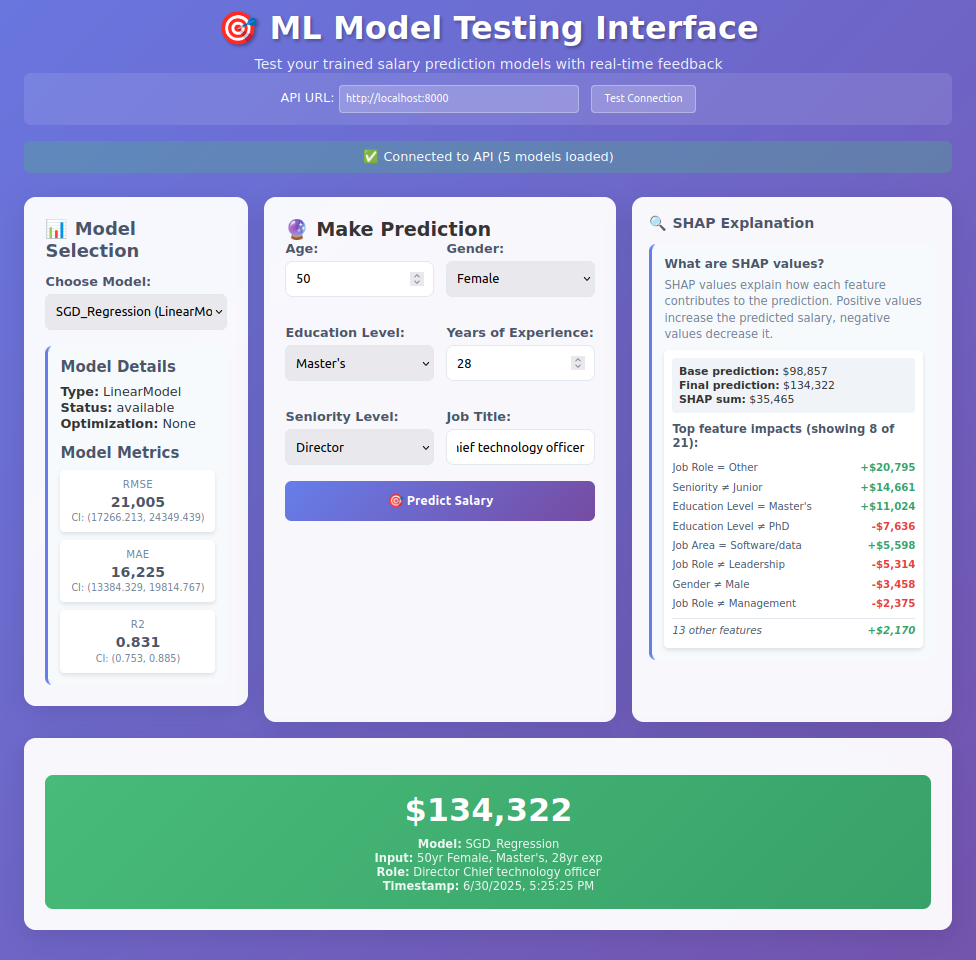

# Running the Application and UI

Simple, standing in the root folder of the project, run:

```Bash
python3 src/api/main.py


Once the model has load completely, look for the file: user_interface.html in the src/api/UI folder, and open it in your browser.

Make sure to connect to the API using the same port as the one specified in the `main.py` file (default is 8000).

That's it.

# AI tools that I used

- **OpenAI GPT-4o-mini**: Used for text feature extraction, job title analysis, and filling missing demographic data. 
- **Claude**: Assisted in overall project management, ping ponging, classes structure, API testing, UI design, and code generation.
- **Copilot**: Helped with code completion, UI design, and debugging.
- **Perplexity**: Assisted with checking and providing trusted sources of knowledge.

Total project cost for preprocessing and model calling: U$D 0.34.

This could have been almost $0 if I had done the job extraction features using regex and leaving the openAI model
for more border cases. But I wanted to solve it quick. 